# Shell AD - MAD

This notebook builds upon the decomposition notebook. It uses the preprocessing steps but rather then applying TS decomposition we apply our MAD AD approach.

## Step 1: Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import json
from pathlib import Path

# Add SDK to path
SDK_PATH = Path().resolve().parents[2] / "src" / "sdk" / "python"
sys.path.insert(0, str(SDK_PATH))

from rtdip_sdk.pipelines.anomaly_detection.spark.mad.mad_anomaly_detection import MadAnomalyDetection, DecompositionMadAnomalyDetection, RollingMadScorer, GlobalMadScorer

print("Imports complete")

Imports complete


## Step 2: Load Raw Data

In [2]:
data_path = Path().resolve().parent.parent / "shell" / "data" / "ShellData.parquet"

print(f"Loading: {data_path}")
print(f"File exists: {data_path.exists()}")
print()

df = pd.read_parquet(data_path, columns=['TagName', 'EventTime', 'Value'])

print(f"Loaded {len(df):,} rows")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1024 / 1024:.1f} MB")
print(f"Unique sensors: {df['TagName'].nunique():,}")
print()
df.head()

Loading: /workspaces/amos2025ws03-rtdip-timeseries-forecasting/amos_team_resources/shell/data/ShellData.parquet
File exists: True

Loaded 214,991,102 rows
Memory: 27188.6 MB
Unique sensors: 7,759



,TagName,EventTime,Value
0,A2PS64V0J.:ZUX09R,2024-01-02 20:03:46,0.34
1,A2PS64V0J.:ZUX09R,2024-01-02 16:00:12,0.15
2,A2PS64V0J.:ZUX09R,2024-01-02 11:56:42,0.13
3,A2PS64V0J.:ZUX09R,2024-01-02 07:53:11,0.12
4,A2PS64V0J.:ZUX09R,2024-01-02 03:49:45,0.13


## Step 3: Configuration (EDIT THIS)

Configure the decomposition parameters here:

In [4]:
# ============================================================================
# CONFIGURATION - Edit these variables to customize the decomposition
# ============================================================================

# Sensor selection
np.random.seed(42)
selected_sensor = np.random.choice(df["TagName"].unique())

# Seasonality patterns to extract
# Options: ['daily'], ['weekly'], or ['daily', 'weekly']
patterns = ['daily', 'weekly']

# Extreme outlier capping (recommended to prevent decomposition distortion)
# Only caps values beyond outlier_threshold standard deviations
cap_outliers = True
outlier_threshold = 20.0  # Number of std deviations (20 catches only absurdly extreme values)

# MSTL robust mode (slower but more resistant to outliers)
# Usually not needed if cap_outliers is enabled
use_robust = False

# ============================================================================

print("Configuration:")
print(f"  Sensor: {selected_sensor}")
print(f"  Patterns: {patterns}")
print(f"  Cap outliers: {cap_outliers}")
if cap_outliers:
    print(f"    Threshold: {outlier_threshold} standard deviations")
print(f"  Robust mode: {use_robust}")
print()
print("Ready to proceed with decomposition")

Configuration:
  Sensor: 0MG_U51O0-:010R.OPC51T0O
  Patterns: ['daily', 'weekly']
  Cap outliers: True
    Threshold: 20.0 standard deviations
  Robust mode: False

Ready to proceed with decomposition


## Step 4: Select Sensor

In [5]:
print(f"Filtering to sensor: {selected_sensor}")
df_sensor = df[df['TagName'] == selected_sensor].copy()

print(f"Selected sensor has {len(df_sensor):,} rows ({len(df_sensor)/len(df)*100:.2f}% of total)")

del df

df_sensor.head()

Selected sensor has 20,018 rows (0.01% of total)


,TagName,EventTime,Value
1747823,OCN340TE2MYS.1:AIH,2024-01-05 05:27:55.223,403.09045
1747830,OCN340TE2MYS.1:AIH,2024-01-05 08:56:16.289,403.8535
1747836,OCN340TE2MYS.1:AIH,2024-01-05 15:03:32.301,405.37964
1747837,OCN340TE2MYS.1:AIH,2024-01-05 03:45:14.101,402.7089
1747841,OCN340TE2MYS.1:AIH,2024-01-05 01:17:19.754,402.32733


## Step 5: Preprocess Value Column

In [6]:
print("Preprocessing...")
print()

# Convert EventTime
print("Converting EventTime to datetime...")
df_sensor['EventTime'] = pd.to_datetime(df_sensor['EventTime'], errors='coerce')
invalid_times = df_sensor['EventTime'].isna().sum()
if invalid_times > 0:
    df_sensor = df_sensor.dropna(subset=['EventTime']).copy()
    print(f"  Dropped {invalid_times:,} invalid timestamps")
else:
    print(f"  All timestamps valid")
print()

# Convert Value to numeric
print("Converting Value to numeric...")
if not pd.api.types.is_numeric_dtype(df_sensor['Value']):
    df_sensor['Value'] = pd.to_numeric(df_sensor['Value'], errors='coerce')
    print(f"  Converted to numeric")
else:
    print(f"  Already numeric")
print()

# Remove invalid values
print("Removing NaN and error values (-1)...")
before_len = len(df_sensor)
df_sensor = df_sensor[
    (df_sensor['Value'].notna()) & 
    (df_sensor['Value'] != -1)
].copy()
removed = before_len - len(df_sensor)
print(f"  Removed {removed:,} rows ({removed/before_len*100:.2f}%)")
print(f"  Remaining: {len(df_sensor):,} rows")
print()

# Sort by time
df_sensor = df_sensor.sort_values('EventTime').reset_index(drop=True)
print("Sorted by time")
print()

print(f"Time range: {df_sensor['EventTime'].min()} to {df_sensor['EventTime'].max()}")
print(f"Duration: {df_sensor['EventTime'].max() - df_sensor['EventTime'].min()}")
print()
print("Value statistics:")
print(df_sensor['Value'].describe())

Preprocessing...

Converting EventTime to datetime...
  All timestamps valid

Converting Value to numeric...
  Converted to numeric

Removing NaN and error values (-1)...
  Removed 0 rows (0.00%)
  Remaining: 20,018 rows

Sorted by time

Time range: 2023-12-31 00:00:13.837000 to 2024-01-29 23:57:07.189000
Duration: 29 days 23:56:53.352000

Value statistics:
count    20018.000000
mean       408.017693
std          8.516370
min        379.435300
25%        403.662720
50%        408.622680
75%        414.154900
max        419.496400
Name: Value, dtype: float64


## Step 6: Analyze Original Sampling Pattern

In [7]:
print("Analyzing original sampling intervals...")
print("="*80)

time_diffs = df_sensor['EventTime'].diff().dropna()

print("\nSampling statistics:")
print(f"  Median:  {time_diffs.median()}")
print(f"  Mean:    {time_diffs.mean()}")
print(f"  Min:     {time_diffs.min()}")
print(f"  Max:     {time_diffs.max()}")
print()
print("Percentiles:")
for p in [25, 50, 75, 90, 95, 99]:
    print(f"  {p:2d}th: {time_diffs.quantile(p/100)}")

# Find large gaps
median_interval = time_diffs.median()
gap_threshold = median_interval * 10
gaps = time_diffs[time_diffs > gap_threshold]

print(f"\nGaps larger than {gap_threshold}: {len(gaps)}")
if len(gaps) > 0:
    print("\nLargest 5 gaps:")
    for i, (idx, gap_size) in enumerate(gaps.nlargest(5).items(), 1):
        gap_start = df_sensor.loc[idx-1, 'EventTime']
        gap_end = df_sensor.loc[idx, 'EventTime']
        print(f"  {i}. {gap_size} from {gap_start} to {gap_end}")

Analyzing original sampling intervals...

Sampling statistics:
  Median:  0 days 00:01:00.668000
  Mean:    0 days 00:02:09.480609082
  Min:     0 days 00:00:02.208000
  Max:     0 days 00:10:00

Percentiles:
  25th: 0 days 00:01:00.356000
  50th: 0 days 00:01:00.668000
  75th: 0 days 00:02:02.382000
  90th: 0 days 00:05:01.033400
  95th: 0 days 00:07:01.575000
  99th: 0 days 00:10:00

Gaps larger than 0 days 00:10:06.680000: 0


## Step 7: Resample to 1-Minute Intervals

Resampling aggregates all values within each 1-minute bin using the mean.

In [8]:
print("Resampling to 1-minute intervals...")
print("="*80)

resample_freq = '1T'  # 1 minute
print(f"Resampling frequency: {resample_freq} (1 minute)")
print(f"Aggregation: mean (average of all values in each minute)")
print()

# Resample
df_resampled = df_sensor.set_index('EventTime').resample(resample_freq)['Value'].mean().reset_index()

print(f"Original points: {len(df_sensor):,}")
print(f"Resampled to: {len(df_resampled):,} 1-minute intervals")
print()

# Check missing values
missing_count = df_resampled['Value'].isna().sum()
print(f"Missing values after resampling: {missing_count:,} ({missing_count/len(df_resampled)*100:.2f}%)")

if missing_count > 0:
    # Analyze gap distribution
    is_nan = df_resampled['Value'].isna()
    nan_groups = (is_nan != is_nan.shift()).cumsum()
    nan_sequences = df_resampled[is_nan].groupby(nan_groups).size()
    
    print(f"\nGap analysis:")
    print(f"  Number of gaps: {len(nan_sequences)}")
    print(f"  Smallest gap: {nan_sequences.min()} minutes")
    print(f"  Largest gap: {nan_sequences.max()} minutes ({nan_sequences.max()/60:.1f} hours)")
    print(f"  Mean gap: {nan_sequences.mean():.1f} minutes")
    print(f"  Median gap: {nan_sequences.median():.0f} minutes")

df_resampled.head(10)

Resampling to 1-minute intervals...
Resampling frequency: 1T (1 minute)
Aggregation: mean (average of all values in each minute)

Original points: 20,018
Resampled to: 43,198 1-minute intervals

Missing values after resampling: 23,272 (53.87%)

Gap analysis:
  Number of gaps: 8849
  Smallest gap: 1 minutes
  Largest gap: 9 minutes (0.1 hours)
  Mean gap: 2.6 minutes
  Median gap: 2 minutes


,EventTime,Value
0,2023-12-31 00:00:00,404.8073
1,2023-12-31 00:01:00,404.9981
2,2023-12-31 00:02:00,NaN
3,2023-12-31 00:03:00,404.8073
4,2023-12-31 00:04:00,404.9981
5,2023-12-31 00:05:00,NaN
6,2023-12-31 00:06:00,NaN
7,2023-12-31 00:07:00,NaN
8,2023-12-31 00:08:00,NaN
9,2023-12-31 00:09:00,404.8073


## Step 8: Interpolate All Missing Values

Using time-based interpolation which accounts for the actual time duration of gaps.

In [9]:
print("Interpolating all missing values...")
print("="*80)

missing_before = df_resampled['Value'].isna().sum()
print(f"Missing values before interpolation: {missing_before:,}")
print(f"Interpolation method: time-based (accounts for gap duration)")
print(f"Limit: None (interpolate all gaps)")
print()

# Set index for time-based interpolation
df_interpolated = df_resampled.set_index('EventTime')

# Interpolate with time method
df_interpolated['Value'] = df_interpolated['Value'].interpolate(
    method='time',
    limit_direction='both'
)

df_interpolated = df_interpolated.reset_index()

# Check results
missing_after = df_interpolated['Value'].isna().sum()
interpolated_count = missing_before - missing_after

print(f"Interpolated: {interpolated_count:,} values ({interpolated_count/len(df_interpolated)*100:.2f}%)")
print(f"Remaining NaN: {missing_after:,}")

if missing_after > 0:
    print(f"\nWarning: {missing_after} values still missing (likely at start/end)")
    print("Removing remaining NaN values...")
    df_interpolated = df_interpolated.dropna(subset=['Value']).reset_index(drop=True)
    print(f"Final dataset: {len(df_interpolated):,} rows")

print(f"\nComplete dataset with no gaps: {df_interpolated['Value'].notna().all()}")

Interpolating all missing values...
Missing values before interpolation: 23,272
Interpolation method: time-based (accounts for gap duration)
Limit: None (interpolate all gaps)

Interpolated: 23,272 values (53.87%)
Remaining NaN: 0

Complete dataset with no gaps: True


## Step 9: Visualize Before/After Interpolation

Compare original data points vs resampled + interpolated data

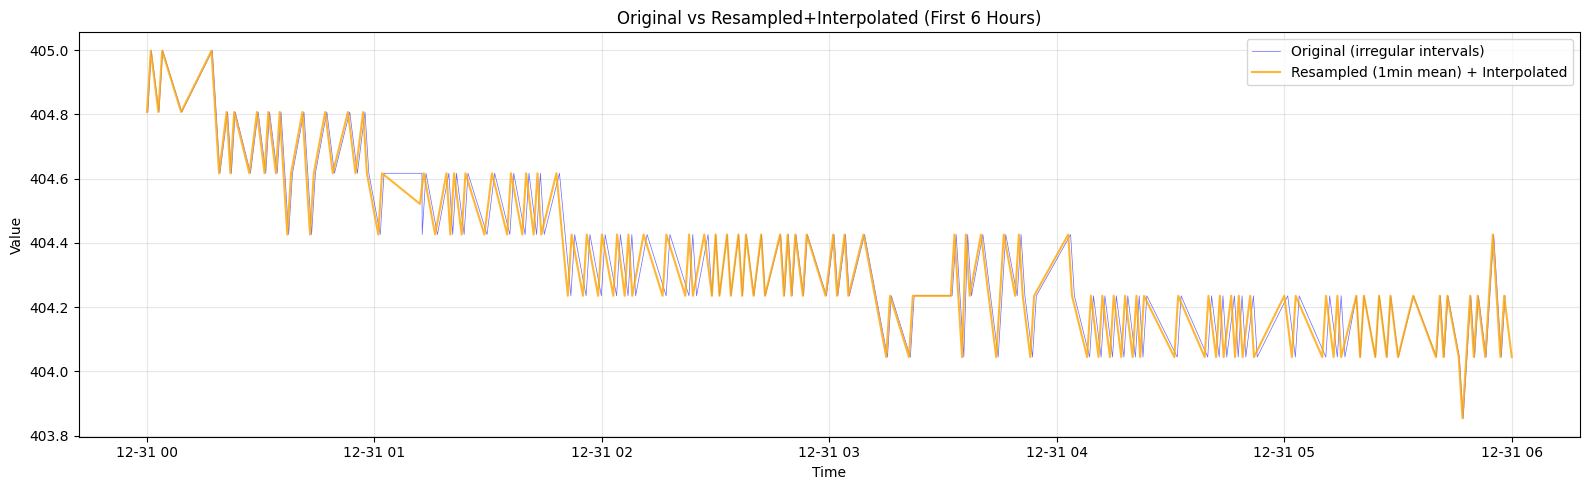

Original data: 173 points (irregular intervals)
Resampled data: 361 points (regular 1-minute intervals)
\nVariance comparison:
  Original: 0.057588
  Resampled: 0.056161
  Reduction: 2.5%


In [10]:
# Take a 6-hour window to see detail
start_time = df_interpolated['EventTime'].min()
window_end = start_time + pd.Timedelta(hours=6)

# Filter data
original_window = df_sensor[(df_sensor['EventTime'] >= start_time) & (df_sensor['EventTime'] <= window_end)]
interpolated_window = df_interpolated[(df_interpolated['EventTime'] >= start_time) & (df_interpolated['EventTime'] <= window_end)]

fig, ax = plt.subplots(figsize=(16, 5))

# Both as lines to compare variance
ax.plot(original_window['EventTime'], original_window['Value'], 
        linewidth=0.5, alpha=0.6, label='Original (irregular intervals)', color='blue')
ax.plot(interpolated_window['EventTime'], interpolated_window['Value'], 
        linewidth=1.5, alpha=0.8, label='Resampled (1min mean) + Interpolated', color='orange')

ax.set_title(f'Original vs Resampled+Interpolated (First 6 Hours)')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('interpolation_comparison.png', dpi=150)
plt.show()

print(f"Original data: {len(original_window):,} points (irregular intervals)")
print(f"Resampled data: {len(interpolated_window):,} points (regular 1-minute intervals)")
print(f"\\nVariance comparison:")
print(f"  Original: {original_window['Value'].var():.6f}")
print(f"  Resampled: {interpolated_window['Value'].var():.6f}")
print(f"  Reduction: {(1 - interpolated_window['Value'].var()/original_window['Value'].var())*100:.1f}%")

## Step 9: All Available Data Info

In [11]:
print("Using all available data...")
print("="*80)

# Use full dataset
df_full = df_interpolated.copy()

start_time = df_full['EventTime'].min()
end_time = df_full['EventTime'].max()
total_duration = end_time - start_time

print(f"Full dataset:")
print(f"  Start: {start_time}")
print(f"  End: {end_time}")
print(f"  Duration: {total_duration}")
print(f"  Days: {total_duration.days + total_duration.seconds/(24*3600):.1f}")
print(f"  Points: {len(df_full):,}")
print()

# Calculate periods (1-minute resampling)
daily_period = 60 * 24  # 1440 minutes per day
weekly_period = 60 * 24 * 7  # 10080 minutes per week

print(f"Periods for MSTL:")
print(f"  Daily: {daily_period} observations (24 hours)")
print(f"  Weekly: {weekly_period} observations (7 days)")
print()

# Check sufficiency
min_required_daily = daily_period * 2
min_required_weekly = weekly_period * 2

print(f"Data requirements:")
print(f"  For daily pattern: need >= {min_required_daily:,} points (2 days)")
print(f"  For weekly pattern: need >= {min_required_weekly:,} points (14 days)")
print(f"  Available: {len(df_full):,} points")
print()

if len(df_full) >= min_required_weekly:
    print(f"Sufficient data for both daily and weekly patterns")
    use_weekly = True
elif len(df_full) >= min_required_daily:
    print(f"Sufficient data for daily pattern only (not enough for weekly)")
    use_weekly = False
else:
    print(f"Insufficient data for decomposition")
    use_weekly = False

Using all available data...
Full dataset:
  Start: 2023-12-31 00:00:00
  End: 2024-01-29 23:57:00
  Duration: 29 days 23:57:00
  Days: 30.0
  Points: 43,198

Periods for MSTL:
  Daily: 1440 observations (24 hours)
  Weekly: 10080 observations (7 days)

Data requirements:
  For daily pattern: need >= 2,880 points (2 days)
  For weekly pattern: need >= 20,160 points (14 days)
  Available: 43,198 points

Sufficient data for both daily and weekly patterns


## Step 10: Visualize Data Before Decomposition

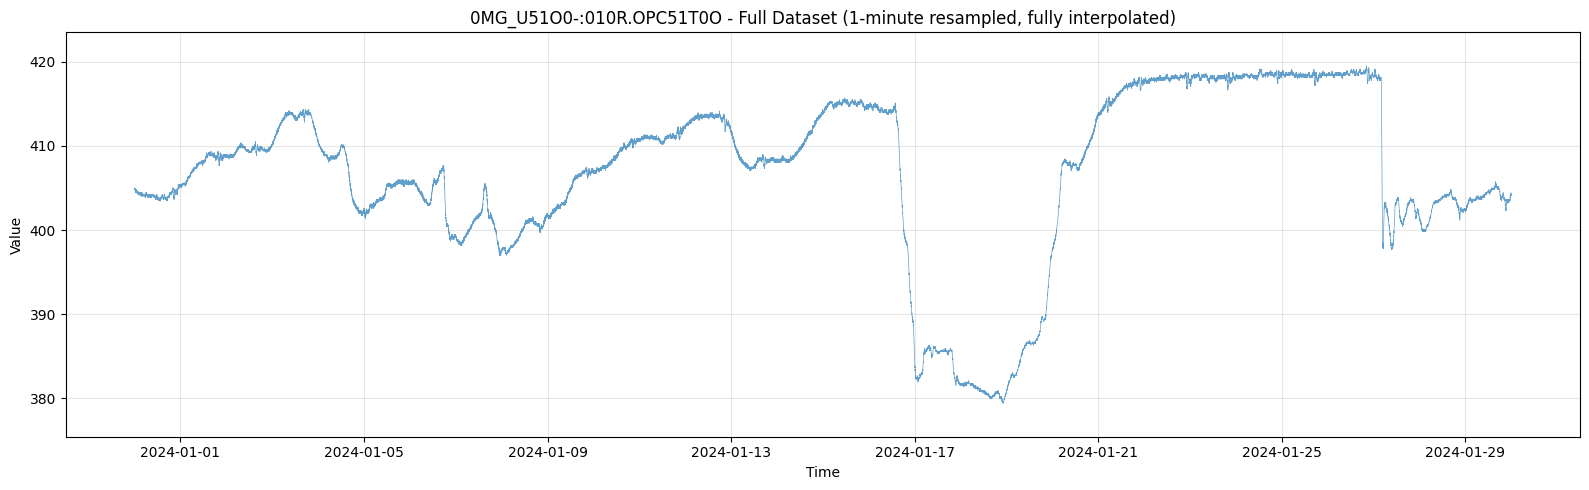

Data characteristics:
  Mean: 406.9484
  Std: 9.7469
  Min: 379.4353
  Max: 419.4964
  Range: 40.0611


In [12]:
fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(df_full['EventTime'], df_full['Value'], linewidth=0.5, alpha=0.7)
ax.set_title(f'{selected_sensor} - Full Dataset (1-minute resampled, fully interpolated)')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.grid(True, alpha=0.3)

# Set y-axis limits based on actual data range with some padding
value_min = df_full['Value'].min()
value_max = df_full['Value'].max()
value_range = value_max - value_min
padding = value_range * 0.1  # 10% padding
ax.set_ylim(value_min - padding, value_max + padding)

plt.tight_layout()
plt.savefig('data_before_decomposition.png', dpi=150)
plt.show()

print(f"Data characteristics:")
print(f"  Mean: {df_full['Value'].mean():.4f}")
print(f"  Std: {df_full['Value'].std():.4f}")
print(f"  Min: {df_full['Value'].min():.4f}")
print(f"  Max: {df_full['Value'].max():.4f}")
print(f"  Range: {value_range:.4f}")

## Step 10: Cap Extreme Outliers (Optional)

Only caps absurdly extreme outliers (beyond `outlier_threshold` standard deviations) to prevent them from distorting the seasonal patterns. This uses a two-stage approach:
1. Identifies values beyond the std deviation threshold
2. Among those, caps to 0.1st/99.9th percentiles

This preserves natural variation while removing sensor malfunctions.

In [23]:
if cap_outliers:
    print("Checking for extreme outliers...")
    print("="*80)
    
    mean = df_full['Value'].mean()
    std = df_full['Value'].std()
    
    # Stage 1: Identify absurdly extreme values (beyond n_std standard deviations)
    lower_extreme = mean - outlier_threshold * std
    upper_extreme = mean + outlier_threshold * std
    
    extreme_mask = (df_full['Value'] < lower_extreme) | (df_full['Value'] > upper_extreme)
    extreme_count = extreme_mask.sum()
    
    print(f"Data statistics:")
    print(f"  Mean: {mean:.4f}")
    print(f"  Std: {std:.4f}")
    print(f"Extreme outlier threshold ({outlier_threshold} std):")
    print(f"  Lower: {lower_extreme:.4f}")
    print(f"  Upper: {upper_extreme:.4f}")
    print(f"Found {extreme_count} extreme outliers ({extreme_count/len(df_full)*100:.3f}%)")
    print()
    
    if extreme_count > 0:
        # Stage 2: For extreme outliers, cap to percentiles
        q99_9 = df_full['Value'].quantile(0.999)
        q00_1 = df_full['Value'].quantile(0.001)
        
        # Only cap values that are BOTH extreme (beyond n_std) AND beyond percentiles
        cap_lower = (df_full['Value'] < lower_extreme) & (df_full['Value'] < q00_1)
        cap_upper = (df_full['Value'] > upper_extreme) & (df_full['Value'] > q99_9)
        outliers_total = cap_lower.sum() + cap_upper.sum()
        
        print(f"Capping thresholds:")
        print(f"  Lower (0.1st percentile): {q00_1:.4f}")
        print(f"  Upper (99.9th percentile): {q99_9:.4f}")
        print(f"Values to cap: {outliers_total}")
        print()
        
        if outliers_total > 0:
            # Show most extreme values
            extreme_values = df_full[extreme_mask].copy()
            extreme_high = extreme_values.nlargest(min(5, len(extreme_values)), 'Value')
            extreme_low = extreme_values.nsmallest(min(5, len(extreme_values)), 'Value')
            
            if len(extreme_high) > 0:
                print("Most extreme high values:")
                for idx, row in extreme_high.iterrows():
                    print(f"  {row['EventTime']}: {row['Value']:.4f} (>{upper_extreme:.1f})")
            
            if len(extreme_low) > 0 and extreme_low['Value'].min() < lower_extreme:
                print("Most extreme low values:")
                for idx, row in extreme_low.iterrows():
                    if row['Value'] < lower_extreme:
                        print(f"  {row['EventTime']}: {row['Value']:.4f} (<{lower_extreme:.1f})")
            print()
            
            # Cap the values
            df_full['Value'] = df_full['Value'].clip(lower=q00_1, upper=q99_9)
            
            print(f"After capping:")
            print(f"  Min: {df_full['Value'].min():.4f}")
            print(f"  Max: {df_full['Value'].max():.4f}")
            
            outlier_metadata = {
                'method': 'std_deviation + percentile',
                'std_threshold': outlier_threshold,
                'lower_percentile': 0.001,
                'upper_percentile': 0.999,
                'outliers_capped': int(outliers_total)
            }
        else:
            print("No values need capping")
            outlier_metadata = {
                'method': 'std_deviation + percentile',
                'std_threshold': outlier_threshold,
                'outliers_capped': 0
            }
    else:
        print("No extreme outliers to cap")
        outlier_metadata = {
            'method': 'std_deviation + percentile',
            'std_threshold': outlier_threshold,
            'outliers_capped': 0
        }
else:
    print("Skipping outlier capping (cap_outliers=False)")
    outlier_metadata = {
        'method': 'none',
        'outliers_capped': 0
    }

Checking for extreme outliers...
Data statistics:
  Mean: -0.4204
  Std: 1.2260
Extreme outlier threshold (20.0 std):
  Lower: -24.9397
  Upper: 24.0990
Found 1 extreme outliers (0.002%)

Capping thresholds:
  Lower (0.1st percentile): -1.6219
  Upper (99.9th percentile): 0.9962
Values to cap: 1

Most extreme high values:
  2024-02-28 19:48:00: 249.0000 (>24.1)

After capping:
  Min: -1.6219
  Max: 0.9962


In [13]:
# Investigate outliers in the data
print("Outlier Investigation")
print("="*80)

# Find extreme values
q1 = df_full['Value'].quantile(0.25)
q3 = df_full['Value'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 3 * iqr
upper_bound = q3 + 3 * iqr

outliers = df_full[(df_full['Value'] < lower_bound) | (df_full['Value'] > upper_bound)]

print(f"IQR-based outlier detection:")
print(f"  Q1: {q1:.4f}")
print(f"  Q3: {q3:.4f}")
print(f"  IQR: {iqr:.4f}")
print(f"  Lower bound (Q1 - 3*IQR): {lower_bound:.4f}")
print(f"  Upper bound (Q3 + 3*IQR): {upper_bound:.4f}")
print()
print(f"Found {len(outliers)} outliers ({len(outliers)/len(df_full)*100:.3f}%)")
print()

if len(outliers) > 0:
    print("Top 10 outliers by absolute deviation from median:")
    median = df_full['Value'].median()
    outliers_sorted = outliers.copy()
    outliers_sorted['abs_dev'] = (outliers_sorted['Value'] - median).abs()
    outliers_sorted = outliers_sorted.sort_values('abs_dev', ascending=False)
    
    for i, (idx, row) in enumerate(outliers_sorted.head(10).iterrows(), 1):
        print(f"  {i}. Time: {row['EventTime']}, Value: {row['Value']:.4f}, Deviation: {row['abs_dev']:.4f}")
    
    print()
    print(f"Outlier statistics:")
    print(f"  Min: {outliers['Value'].min():.4f}")
    print(f"  Max: {outliers['Value'].max():.4f}")
    print(f"  Mean: {outliers['Value'].mean():.4f}")
    print(f"  Median: {outliers['Value'].median():.4f}")

Outlier Investigation
IQR-based outlier detection:
  Q1: -0.5530
  Q3: -0.3148
  IQR: 0.2382
  Lower bound (Q1 - 3*IQR): -1.2677
  Upper bound (Q3 + 3*IQR): 0.3999

Found 549 outliers (1.278%)

Top 10 outliers by absolute deviation from median:
  1. Time: 2024-02-28 19:48:00, Value: 249.0000, Deviation: 249.4494
  2. Time: 2024-02-18 16:50:00, Value: 5.6669, Deviation: 6.1164
  3. Time: 2024-02-18 16:51:00, Value: 4.7358, Deviation: 5.1852
  4. Time: 2024-02-18 16:52:00, Value: 2.4626, Deviation: 2.9120
  5. Time: 2024-02-18 16:53:00, Value: 2.3036, Deviation: 2.7531
  6. Time: 2024-02-18 16:54:00, Value: 2.0705, Deviation: 2.5199
  7. Time: 2024-02-18 16:56:00, Value: 2.0178, Deviation: 2.4672
  8. Time: 2024-02-18 16:57:00, Value: 1.9830, Deviation: 2.4325
  9. Time: 2024-02-18 16:58:00, Value: 1.9576, Deviation: 2.4071
  10. Time: 2024-02-18 16:55:00, Value: 1.9545, Deviation: 2.4039

Outlier statistics:
  Min: -2.6679
  Max: 249.0000
  Mean: 0.7511
  Median: 0.4756


In [17]:
# save cleaned data

df_full.to_csv("/workspaces/amos2025ws03-rtdip-timeseries-forecasting/amos_team_resources/anomaly_detection/mad/prep_data.csv")

## Step 11: Apply AD

In [22]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

df_full_spark = spark.createDataFrame(df_full)

df_full_spark = (
    df_full_spark
    .withColumnRenamed("EventTime", "timestamp")
    .withColumnRenamed("Value", "value")
)

print(df_full_spark.show(5))

+-------------------+--------+
|          timestamp|   value|
+-------------------+--------+
|2023-12-31 00:00:00|404.8073|
|2023-12-31 00:01:00|404.9981|
|2023-12-31 00:02:00|404.9027|
|2023-12-31 00:03:00|404.8073|
|2023-12-31 00:04:00|404.9981|
+-------------------+--------+
only showing top 5 rows

None


In [23]:
global_mad = MadAnomalyDetection()

df_anomalies_global = global_mad.detect(df_full_spark)

print("Global MAD anomalies:")
df_anomalies_global.show(10, truncate=False)

Global MAD anomalies:
+-------------------+-----------------+-------------------+----------+
|timestamp          |value            |mad_zscore         |is_anomaly|
+-------------------+-----------------+-------------------+----------+
|2024-01-18 21:59:00|379.483          |-3.5007272116898744|true      |
|2024-01-18 22:00:00|379.4353         |-3.5065030813111364|true      |
|2024-01-18 22:02:00|379.4353         |-3.5065030813111364|true      |
|2024-01-18 22:04:00|379.4353         |-3.5065030813111364|true      |
|2024-01-18 22:06:00|379.4353         |-3.5065030813111364|true      |
|2024-01-18 22:08:00|379.4353         |-3.5065030813111364|true      |
|2024-01-18 22:09:00|379.4625571428571|-3.503202584384703 |true      |
|2024-01-18 22:17:00|379.4353         |-3.5065030813111364|true      |
|2024-01-18 22:20:00|379.4353         |-3.5065030813111364|true      |
|2024-01-18 22:24:00|379.4353         |-3.5065030813111364|true      |
+-------------------+-----------------+----------------

In [24]:
rolling_mad = MadAnomalyDetection(
    scorer=RollingMadScorer()
)

df_anomalies_rolling = rolling_mad.detect(df_full_spark)

print("Rolling MAD anomalies:")
df_anomalies_rolling.show(10, truncate=False)

Rolling MAD anomalies:
+-------------------+---------+------------------+----------+
|timestamp          |value    |mad_zscore        |is_anomaly|
+-------------------+---------+------------------+----------+
|2024-01-27 04:15:00|412.05646|-3.870899853749971|true      |
|2024-01-27 04:16:00|411.48413|-4.117532465000016|true      |
|2024-01-27 04:17:00|410.7211 |-4.439188025000012|true      |
|2024-01-27 04:18:00|409.95804|-4.436681079380841|true      |
+-------------------+---------+------------------+----------+



In [25]:
stl_mad = DecompositionMadAnomalyDetection(
    scorer=GlobalMadScorer(),
    decomposition="stl",
    period=1440,                 # 1 day seasonality (1-minute data)
    timestamp_column="timestamp",
    value_column="value"
)

df_anomalies_stl = stl_mad.detect(df_full_spark)

print("STL + MAD anomalies:")
df_anomalies_stl.show(10, truncate=False)

STL + MAD anomalies:
+-------------------+------------------+------------------+-------------------+------------------+------------------+----------+
|timestamp          |value             |trend             |seasonal           |residual          |mad_zscore        |is_anomaly|
+-------------------+------------------+------------------+-------------------+------------------+------------------+----------+
|2024-01-16 12:10:00|414.34567         |408.5370134783736 |0.4324141054495735 |5.376242416176808 |3.6107593872430996|true      |
|2024-01-16 12:12:00|414.34567         |408.49865697753535|0.5003229602045308 |5.346690062260109 |3.5908263245262857|true      |
|2024-01-16 12:13:00|414.1549          |408.4794401508854 |0.43277267520665696|5.242687173907939 |3.520676376332747 |true      |
|2024-01-16 12:15:00|414.1549          |408.4409297552923 |0.4743737891767627 |5.239596455530943 |3.5185916867874636|true      |
|2024-01-16 12:18:00|414.1549          |408.38297354233623|0.485174529972377

In [26]:
stl_rolling_mad = DecompositionMadAnomalyDetection(
    scorer=RollingMadScorer(),
    decomposition="stl",
    period=1440,                 # 1 day seasonality (1-minute data)
    timestamp_column="timestamp",
    value_column="value"
)

df_anomalies_stl_rolling = stl_rolling_mad.detect(df_full_spark)

print("STL + Rolling MAD anomalies:")
df_anomalies_stl_rolling.show(10, truncate=False)

STL + Rolling MAD anomalies:
+-------------------+---------+------------------+---------------------+--------------------+-------------------+----------+
|timestamp          |value    |trend             |seasonal             |residual            |mad_zscore         |is_anomaly|
+-------------------+---------+------------------+---------------------+--------------------+-------------------+----------+
|2024-01-27 04:16:00|411.48413|409.84614640892516|0.16649884389879702  |1.4714847471760208  |-3.649285561394131 |true      |
|2024-01-27 04:17:00|410.7211 |409.8327819025721 |0.10877846183678158  |0.7795396355911066  |-3.94173718203409  |true      |
|2024-01-27 04:18:00|409.95804|409.8194200044528 |0.0023172042142411736|0.13630279133292333 |-4.2180335238236255|true      |
|2024-01-27 04:19:00|409.3857 |409.80606071772155|-0.05404628354411915 |-0.36631443417746823|-3.599958744621109 |true      |
+-------------------+---------+------------------+---------------------+--------------------+---

In [28]:
mstl_mad = DecompositionMadAnomalyDetection(
    scorer=GlobalMadScorer(),
    decomposition="mstl",
    period="daily",
    timestamp_column="timestamp",
    value_column="value"
)

df_anomalies_mstl = mstl_mad.detect(df_full_spark)

print("MSTL + MAD anomalies:")
df_anomalies_mstl.show(10, truncate=False)

25/12/16 19:23:54 ERROR Executor: Exception in task 5.0 in stage 55.0 (TID 298)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/conda/envs/rtdip-sdk/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1094, in main
    split_index = read_int(infile)
                  ^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/rtdip-sdk/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 594, in read_int
    length = stream.read(4)
             ^^^^^^^^^^^^^^
KeyboardInterrupt

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(

Py4JJavaError: An error occurred while calling o366.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 55.0 failed 1 times, most recent failure: Lost task 2.0 in stage 55.0 (TID 295) (7fb1d3338ed5 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/conda/envs/rtdip-sdk/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1094, in main
    split_index = read_int(infile)
                  ^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/rtdip-sdk/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 594, in read_int
    length = stream.read(4)
             ^^^^^^^^^^^^^^
KeyboardInterrupt

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4149)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4146)
	at jdk.internal.reflect.GeneratedMethodAccessor78.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/conda/envs/rtdip-sdk/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1094, in main
    split_index = read_int(infile)
                  ^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/rtdip-sdk/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 594, in read_int
    length = stream.read(4)
             ^^^^^^^^^^^^^^
KeyboardInterrupt

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [ ]:
mstl_rolling_mad = DecompositionMadAnomalyDetection(
    scorer=RollingMadScorer(),
    decomposition="mstl",
    period=1440,                 # 1 day seasonality (1-minute data)
    timestamp_column="timestamp",
    value_column="value"
)

df_anomalies_mstl_rolling = mstl_rolling_mad.detect(df_full_spark)

print("MSTL + Rolling MAD anomalies:")
df_anomalies_mstl_rolling.show(10, truncate=False)

MSTL + Rolling MAD anomalies:
+-------------------+---------+------------------+--------------------+---------------------+-------------------+----------+
|timestamp          |value    |trend             |seasonal_1440       |residual             |mad_zscore         |is_anomaly|
+-------------------+---------+------------------+--------------------+---------------------+-------------------+----------+
|2024-01-27 04:17:00|410.7211 |409.8951019393356 |-0.1988145736943664 |1.0248126343587955   |-3.563670980297982 |true      |
|2024-01-27 04:18:00|409.95804|409.88363985298656|-0.3611373427151621 |0.4355374897285742   |-3.820907645742795 |true      |
|2024-01-27 04:19:00|409.3857 |409.8721795099936 |-0.49302646596330785|0.0065469559696680335|-3.6899758900226045|true      |
+-------------------+---------+------------------+--------------------+---------------------+-------------------+----------+



In [ ]:
import matplotlib.pyplot as plt

def plot_anomalies_single(df_raw_spark, df_anoms_spark, title):
    pdf = df_raw_spark.toPandas().sort_values("timestamp")
    apdf = df_anoms_spark.toPandas().sort_values("timestamp")

    fig, ax = plt.subplots(figsize=(18, 6))

    ax.plot(
        pdf["timestamp"],
        pdf["value"],
        label="value",
        color="steelblue",
        linewidth=1.6,
    )

    if not apdf.empty:
        ax.scatter(
            apdf["timestamp"],
            apdf["value"],
            color="red",
            s=70,
            label="anomaly",
            zorder=5,
        )

    ax.set_title(title, fontsize=14)
    ax.set_xlabel("timestamp")
    ax.set_ylabel("value")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


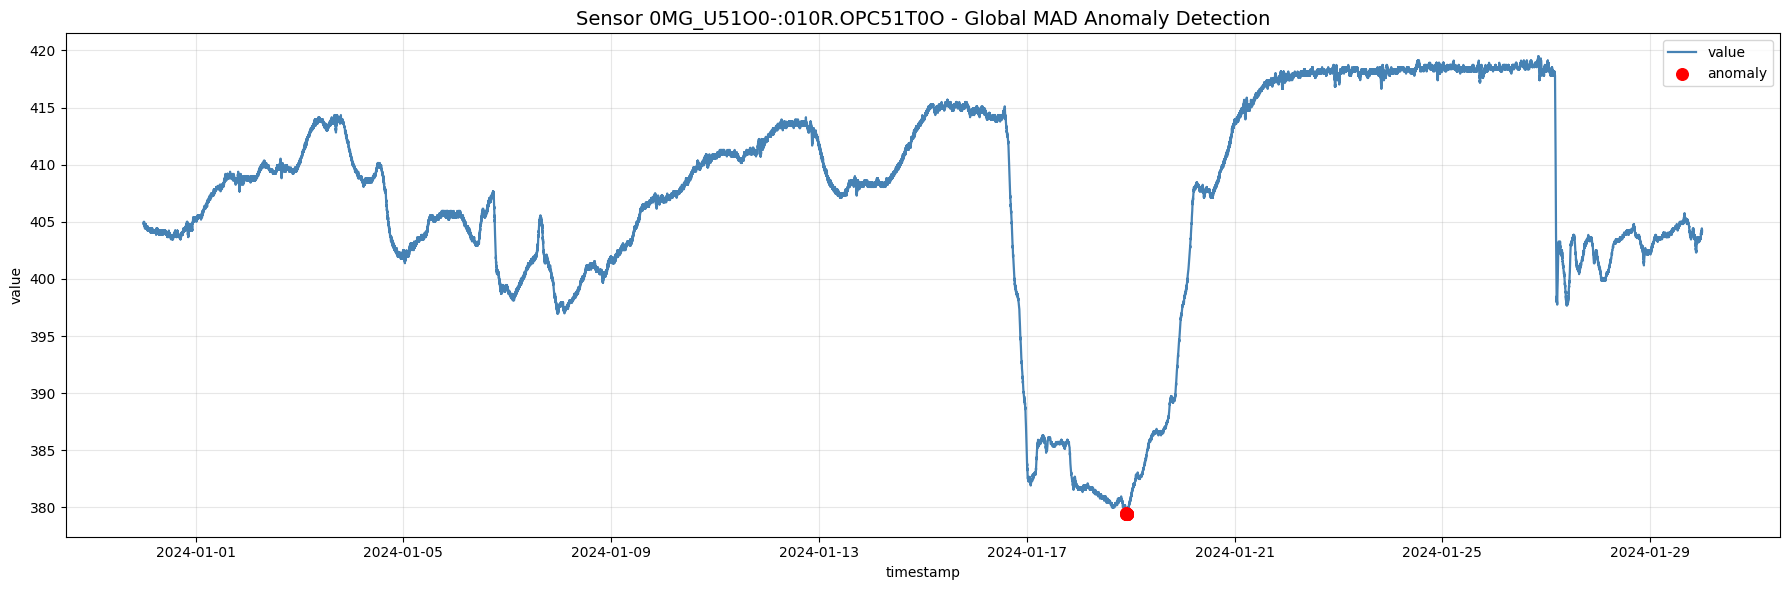

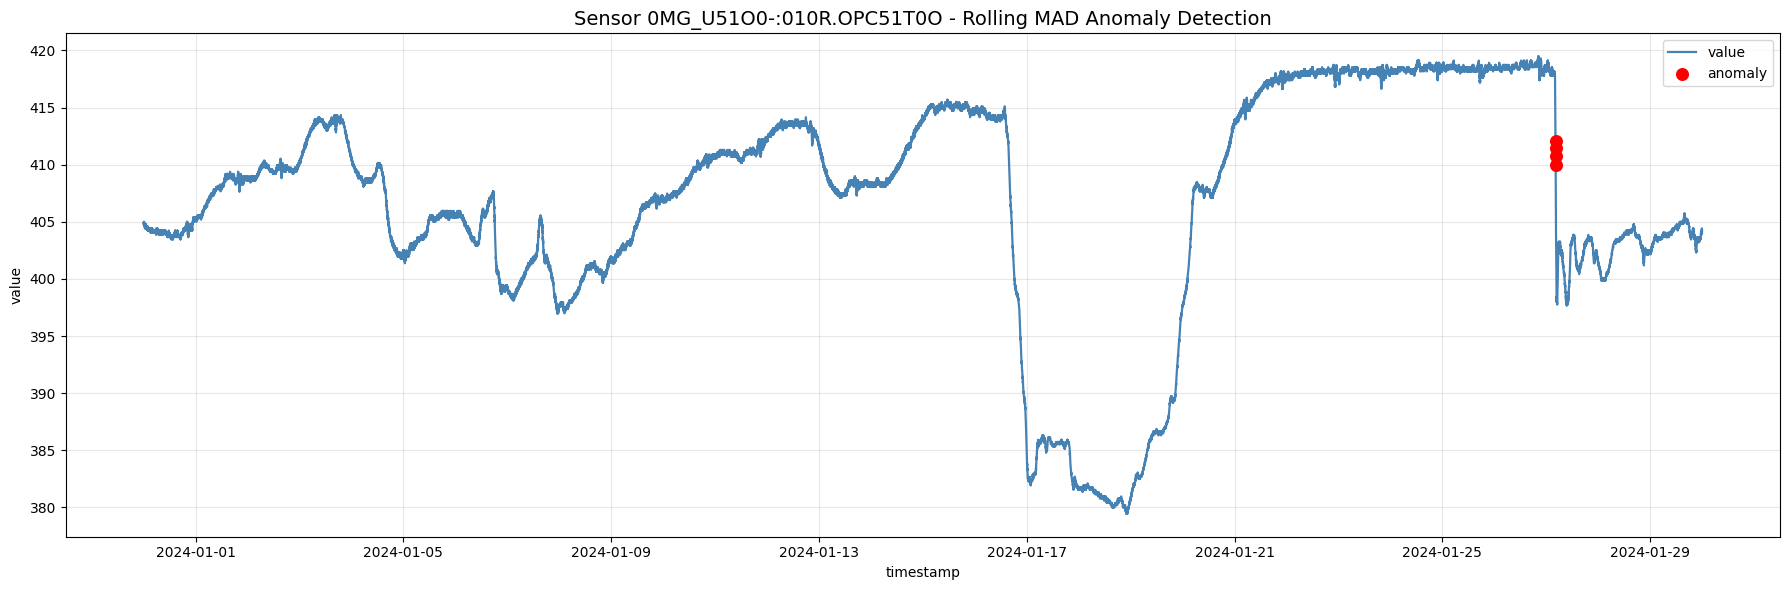

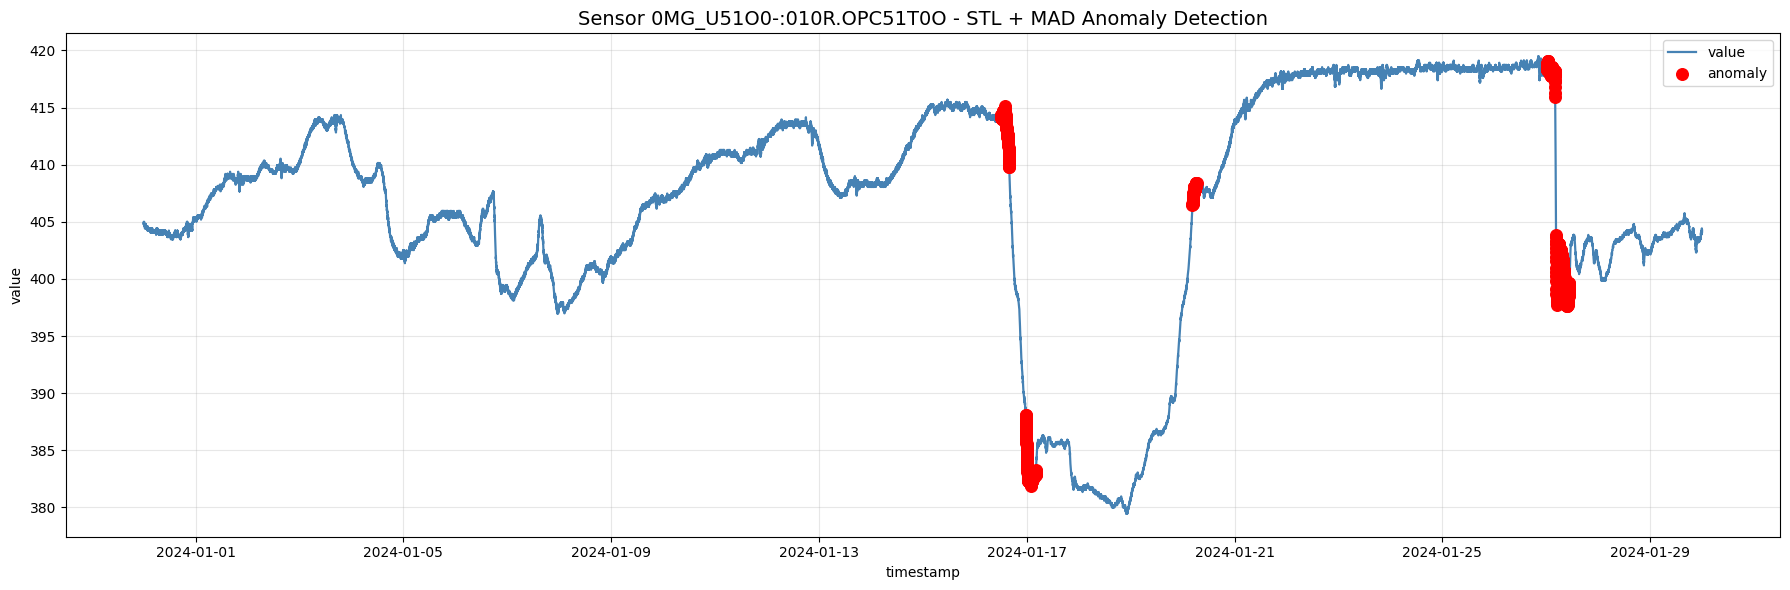

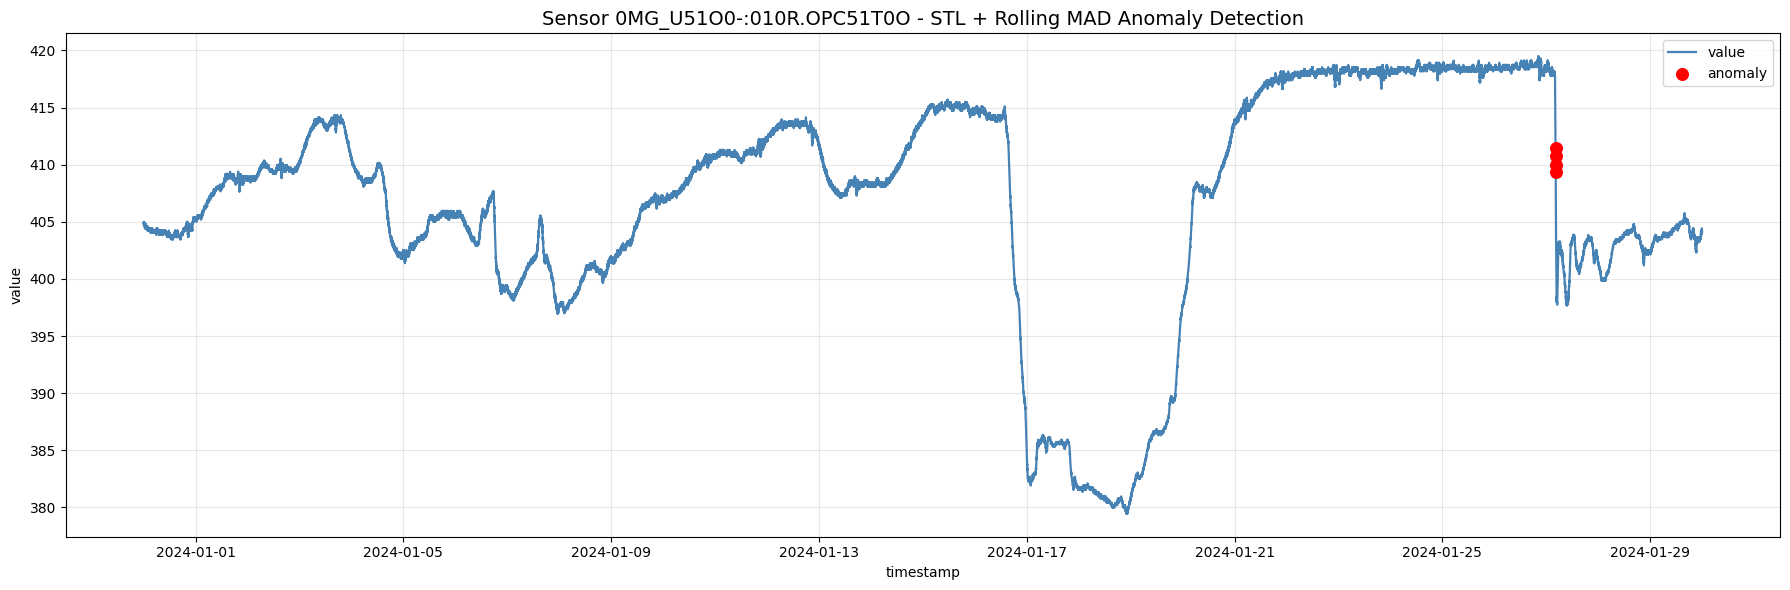

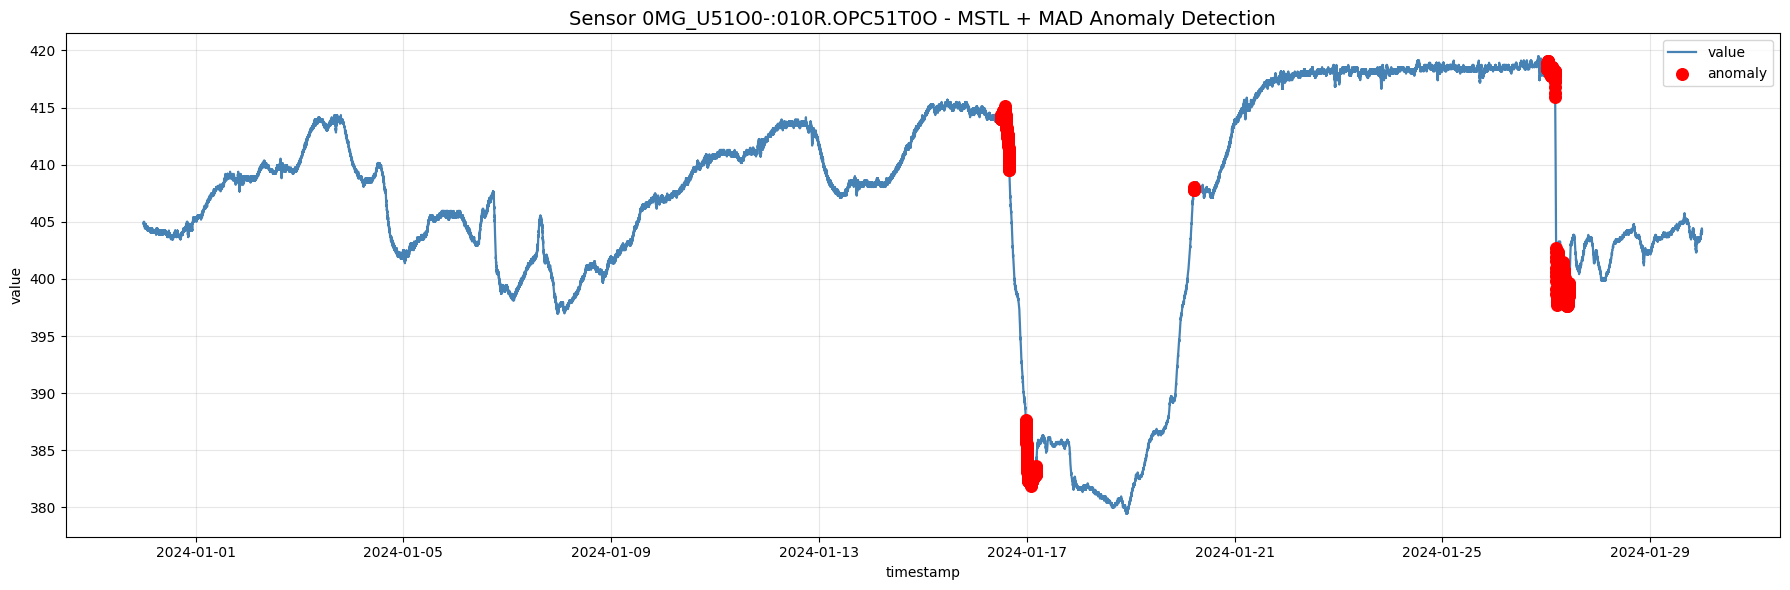

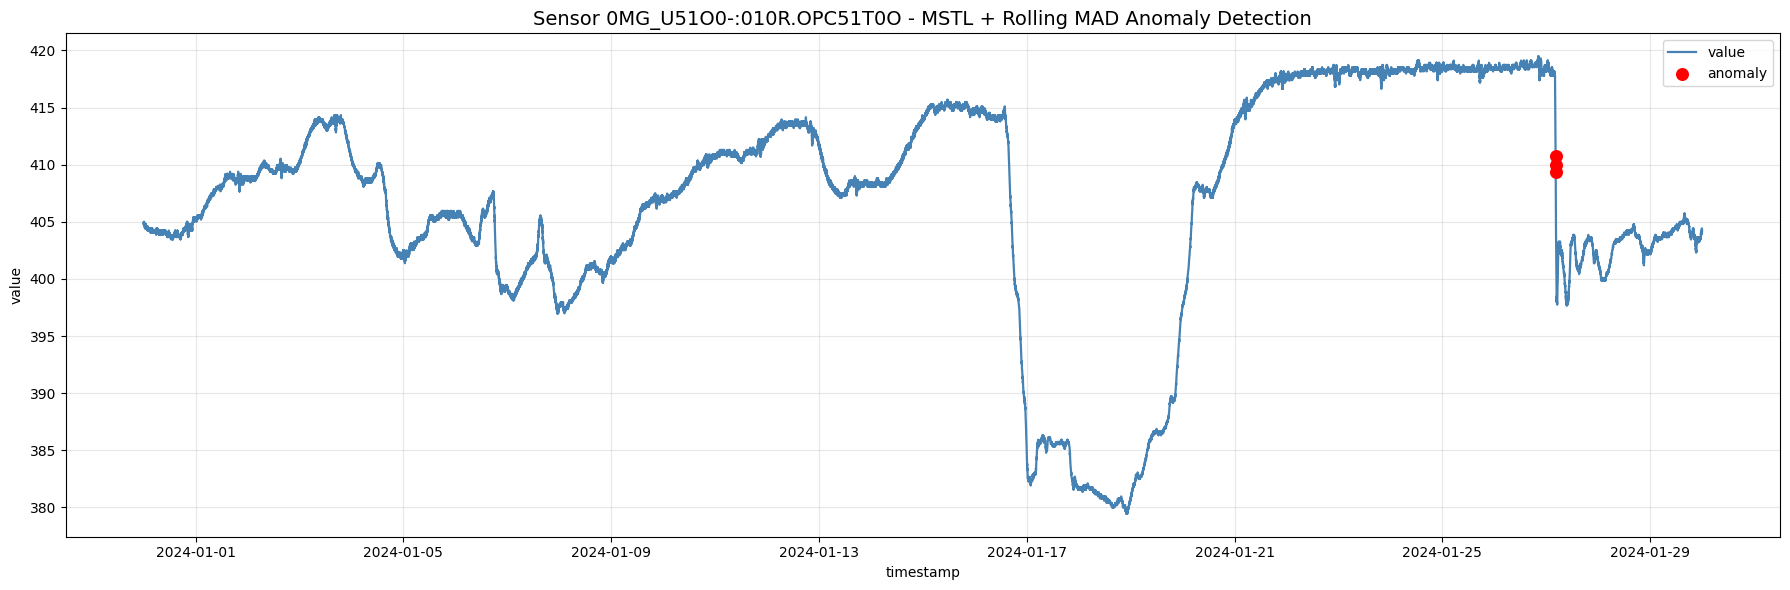

In [ ]:
plot_anomalies_single(
    df_full_spark,
    df_anomalies_global,
    f"Sensor {selected_sensor} - Global MAD Anomaly Detection"
)

plot_anomalies_single(
    df_full_spark,
    df_anomalies_rolling,
    f"Sensor {selected_sensor} - Rolling MAD Anomaly Detection"
)

plot_anomalies_single(
    df_full_spark,
    df_anomalies_stl,
    f"Sensor {selected_sensor} - STL + MAD Anomaly Detection"
)

plot_anomalies_single(
    df_full_spark,
    df_anomalies_stl_rolling,
    f"Sensor {selected_sensor} - STL + Rolling MAD Anomaly Detection"
)

plot_anomalies_single(
    df_full_spark,
    df_anomalies_mstl,
    f"Sensor {selected_sensor} - MSTL + MAD Anomaly Detection"
)

plot_anomalies_single(
    df_full_spark,
    df_anomalies_mstl_rolling,
    f"Sensor {selected_sensor} - MSTL + Rolling MAD Anomaly Detection"
)